In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [3]:
data_dict = torch.load('../../data/summarized_neutron_data_w_bkg_260meV_ML.pt')
print(data_dict.keys())

dict_keys(['grid', 'S', 'background', 'background_dict'])


In [4]:
from src.sqw import SpecNeuralRepr
model_sqw = SpecNeuralRepr.load_from_checkpoint(
    'input/version_14896845/checkpoints/epoch=7160-step=343728.ckpt')

In [5]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [6]:
hklw_grid = torch.vstack([_.unsqueeze(0) for _ in torch.meshgrid(*[v for k, v in data_dict['grid'].items()], indexing='ij')]).permute(1, 2, 3, 4, 0)

In [7]:
from src.dataset import NeighborDataset
from torch.utils.data import DataLoader

In [8]:
dataset = NeighborDataset(hklw_grid, data_dict['S'], neighbor_range=4)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [9]:
from src.kernel import L_Kernel

In [10]:
ckpt_path = 'lightning_logs/sf_net/version_1/checkpoints/last.ckpt'
model_config = torch.load(ckpt_path)['hyper_parameters']['model_config']

In [11]:
params = torch.tensor([32.0, -2.6])

In [12]:
model_sqw.params = params.clone()
L_model = L_Kernel(forward_model=model_sqw, model_config=model_config).to(device)
L_model.load_state_dict(torch.load(ckpt_path)['state_dict'])

<All keys matched successfully>

In [16]:
from tqdm import tqdm
import numpy as np

In [17]:
from src.experiment import NeutronExperiment


experiment_config = {
    "q_grid": tuple([data_dict['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data_dict['grid']['w_grid'],
    "S_grid": data_dict['S'],
    "S_scale_factor": 1.
}

experiment = NeutronExperiment(**experiment_config)
# experiment.prepare_experiment(hklw_grid)

In [18]:
# S_mask = data_dict['S'] > 1e-3
S_mask = torch.ones_like(data_dict['S']).bool()

In [19]:
from tqdm import tqdm
import numpy as np

In [20]:
center_pts_full_grid = hklw_grid.reshape(-1,4)
s_sig_full_grid = torch.zeros((data_dict['S'].numel(), 1,))
s_bkg_full_grid = torch.zeros_like(s_sig_full_grid)

batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 10000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts_full_grid[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig_full_grid[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg_full_grid[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

100%|██████████| 10000/10000 [2:28:00<00:00,  1.13it/s] 


In [21]:
data_dict.keys()

dict_keys(['grid', 'S', 'background', 'background_dict'])

In [29]:
from copy import deepcopy

In [33]:
data_dict_synthetic = {}
data_dict_synthetic['grid'] = data_dict['grid']

In [38]:
data_dict_synthetic['S'] = (s_bkg_full_grid + s_sig_full_grid).reshape(data_dict['S'].shape)

In [39]:
data_dict_synthetic['S_sig'] = s_sig_full_grid.reshape(data_dict['S'].shape)
data_dict_synthetic['S_bkg'] = s_bkg_full_grid.reshape(data_dict['S'].shape)

In [42]:
fname_synthetic = f"../../data/summarized_neutron_data_w_bkg_260meV_synthetic_J{params[0]:.2f}_Jp{params[1]:.2f}.pt"
print(fname_synthetic)

../../data/summarized_neutron_data_w_bkg_260meV_synthetic_J32.00_Jp-2.60.pt


In [43]:
torch.save(data_dict_synthetic, fname_synthetic)

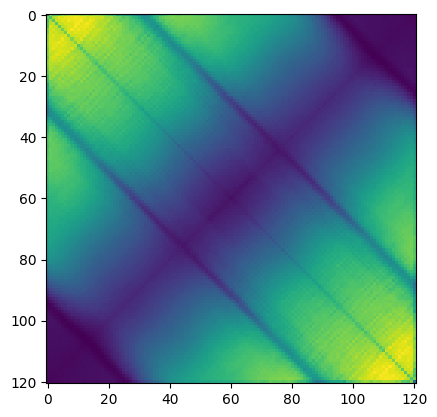

In [48]:
import matplotlib.pyplot as plt
plt.imshow(data_dict_synthetic['S_bkg'].sum(-1).sum(-1))

In [19]:
batches = np.array_split(np.arange(center_pts.view(-1,4).shape[0]), 1000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts.view(-1,4)[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

100%|██████████| 1000/1000 [01:05<00:00, 15.20it/s]


In [20]:
import matplotlib.pyplot as plt

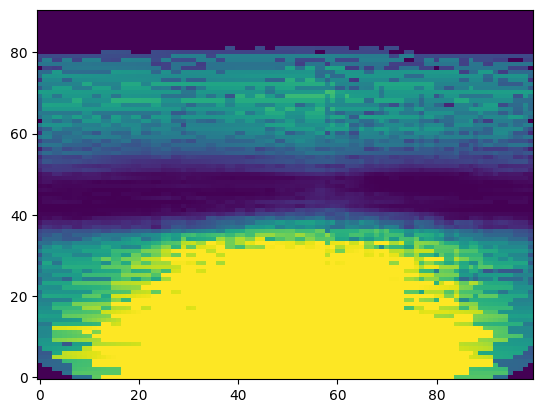

In [21]:
plt.imshow(s_bkg.reshape(center_pts.shape[:-1]).detach().cpu().sum(0), origin='lower', aspect='auto', vmax=20)

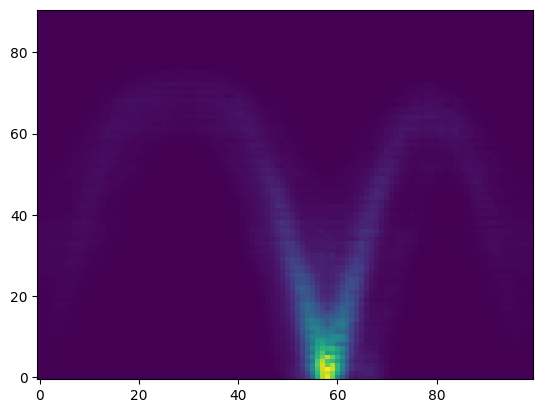

In [22]:
plt.imshow(s_sig.reshape(center_pts.shape[:-1]).sum(0), origin='lower', aspect='auto')

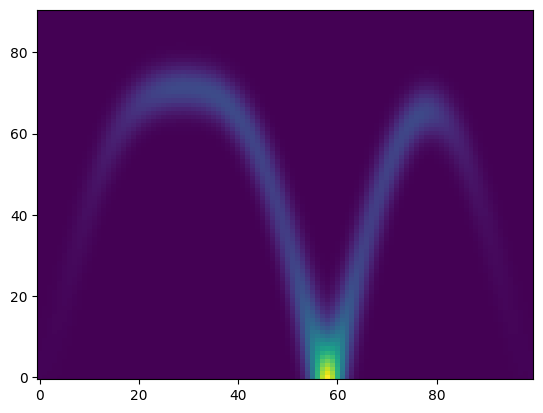

In [23]:
plt.imshow(model_sqw.forward_qw(center_pts.to(device)).cpu().sum(0), origin='lower', aspect='auto')

In [24]:
S_exp = 0.
mask_exp = 0.
for _qw_coords in qw_coords:
    S_exp += experiment.get_measurements_on_coords(_qw_coords)
    mask_exp += experiment.get_mask_on_coords(_qw_coords)

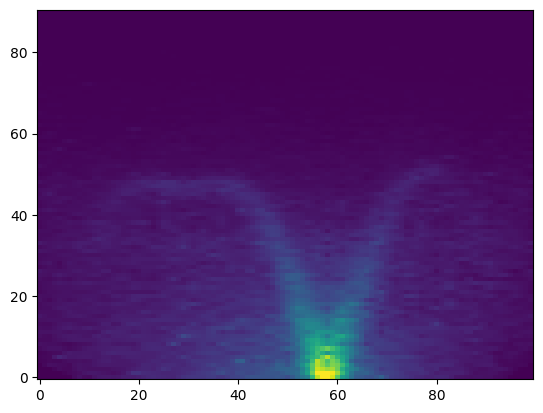

In [25]:
plt.imshow(S_exp, origin='lower', aspect='auto', vmax=300)

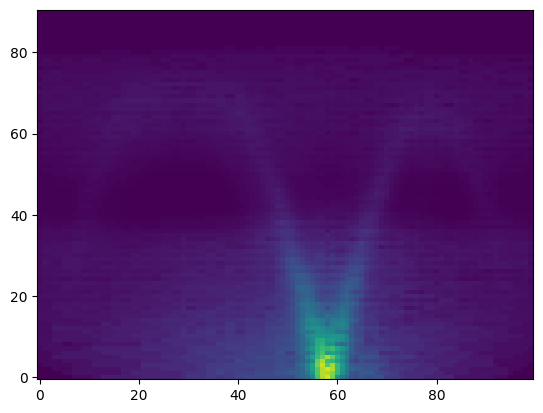

In [26]:
S_exp_pred = (s_sig+s_bkg).reshape(center_pts.shape[:-1]).detach().cpu().sum(0)
plt.imshow(S_exp_pred, origin='lower', aspect='auto', vmax=300)

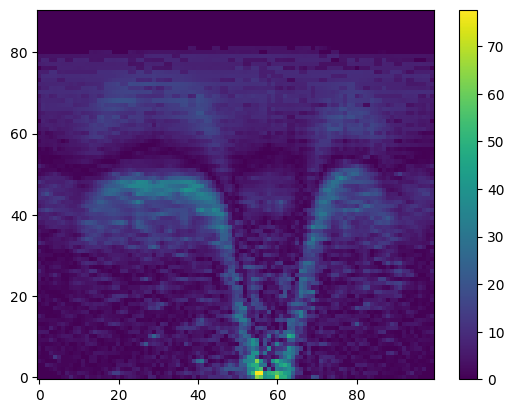

In [27]:
plt.imshow(np.abs(S_exp_pred - S_exp), origin='lower', aspect='auto')
plt.colorbar()

In [37]:
# S_mask = data_dict['S'] > 1e-3
S_mask = torch.ones_like(data_dict['S']).bool()

In [39]:
center_pts_full_grid = hklw_grid.reshape(-1,4)
s_sig_full_grid = torch.zeros((data_dict['S'].numel(), 1,))
s_bkg_full_grid = torch.zeros_like(s_sig_full_grid)

batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 10000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts_full_grid[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig_full_grid[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg_full_grid[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

  0%|          | 0/10000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.15 GiB. GPU  has a total capacity of 79.14 GiB of which 3.74 GiB is free. Including non-PyTorch memory, this process has 75.38 GiB memory in use. Of the allocated memory 66.48 GiB is allocated by PyTorch, and 8.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [38]:
device_new = 'cuda:1'
L_model.to(device_new)

L_Kernel(
  (kernel_net): KernelNet(
    (kernel_net): Sequential(
      (0): SirenNet(
        (layers): ModuleList(
          (0-2): 3 x Siren(
            (activation): Sine()
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (last_layer): Siren(
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=2385, bias=True)
      (4): Softmax(dim=-1)
    )
    (sf_net): Sequential(
      (0): SirenNet(
        (layers): ModuleList(
          (0-2): 3 x Siren(
            (activation): Sine()
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (last_layer): Siren(
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): ReLU()
      (3): Li

In [39]:
center_pts_full_grid = hklw_grid.reshape(-1,4)
s_sig_full_grid = torch.zeros((data_dict['S'].numel(), 1,))
s_bkg_full_grid = torch.zeros_like(s_sig_full_grid)

batches = np.array_split(torch.where(S_mask.reshape(-1))[0], 10000)

for i, batch_idx in tqdm(enumerate(batches), total=len(batches)):
    
    _center_pts = center_pts_full_grid[batch_idx]
    _mask = experiment.get_mask_on_coords(_center_pts.cpu().numpy())
    
    sample_pts, _ = get_neighbors(_center_pts, dim=4, neighbor_range=3, exclude_corner=True, deltas=dataset.deltas)
    s_sample = model_sqw.forward_qw(sample_pts)
    with torch.no_grad():
        kappa = L_model.kernel_net(_center_pts.to(L_model.dtype).to(L_model.device))
        _s_bkg = L_model.bkgd_net(_center_pts.to(L_model.dtype).to(L_model.device)).cpu()
    _s_sig = torch.einsum('ij, ij -> i', kappa, s_sample[:,L_model.kernel_net.kernel_mask_flat]).unsqueeze(-1)
    s_sig_full_grid[batch_idx] = _s_sig.cpu() * torch.from_numpy(_mask).unsqueeze(-1)
    s_bkg_full_grid[batch_idx] = _s_bkg * torch.from_numpy(_mask).unsqueeze(-1)

  0%|          | 0/10000 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.15 GiB. GPU  has a total capacity of 79.14 GiB of which 3.74 GiB is free. Including non-PyTorch memory, this process has 75.38 GiB memory in use. Of the allocated memory 66.48 GiB is allocated by PyTorch, and 8.42 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
plt.imshow(s_sig_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

In [ ]:
plt.imshow(s_bkg_full_grid.reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))

In [ ]:
plt.imshow((s_bkg_full_grid+s_sig_full_grid).reshape(hklw_grid.shape[:-1]).sum(-1).sum(-1))